In [1]:
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_mpl_presets
from scipy.stats import bootstrap, skewnorm, linregress
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import warnings
import random
import vice
import sys
load_mpl_presets()
warnings.filterwarnings("ignore")
print(sys.version_info)

sys.version_info(major=3, minor=10, micro=2, releaselevel='final', serial=0)


/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
columns = ["LINE", "APOGEE_ID", "RA", "DEC", "GALR", "GALPHI", "GALZ", "SNREV", "TEFF", "TEFF_ERR",
    "LOGG", "LOGG_ERR", "FE_H", "FE_H_ERR", "O_FE", "O_FE_ERR", "ASTRONN_AGE", "ASTRONN_AGE_ERR",
    "LATENT_AGE", "LATENT_AGE_ERR"]
raw = np.genfromtxt("../data/Leung2023.csv", delimiter = ',', skip_header = 1, usecols = range(len(columns)))
sample = {}
for i in range(len(columns)):
    sample[columns[i]] = [row[i] for row in raw]
sample["o_h"] = [a + b for a, b in zip(sample["O_FE"], sample["FE_H"])]
sample["o_h_err"] = [np.sqrt(a**2 + b**2) for a, b in zip(sample["O_FE_ERR"], sample["FE_H_ERR"])]
sample["absz"] = [abs(_) for _ in sample["GALZ"]]
sample = vice.dataframe(sample)
print(sample)

vice.dataframe{
    line -----------> [0, 1, 2, ... , 192917, 192918, 192919]
    apogee_id ------> [nan, nan, nan, ... , nan, nan, nan]
    ra -------------> [0.00285, 0.005558, 0.008802, ... , 359.993, 359.995, 359.997]
    dec ------------> [57.1732, 57.3545, 63.4631, ... , 57.0124, 57.435, 56.1633]
    galr -----------> [8.4584, 11.9539, 12.8583, ... , 10.6942, 9.3281, 9.64501]
    galphi ---------> [175.658, 153.655, 151.397, ... , 159.022, 167.511, 165.095]
    galz -----------> [-0.040749, -0.470835, 0.169356, ... , -0.358826, -0.163006, -0.265258]
    snrev ----------> [282.746, 120.295, 169.02, ... , 101.537, 232.918, 88.4561]
    teff -----------> [5031.26, 4974.6, 4681.46, ... , 4954.17, 4859.91, 4585.41]
    teff_err -------> [10.1451, 15.3109, 8.76634, ... , 15.7503, 9.05073, 11.2989]
    logg -----------> [3.45613, 2.38825, 2.24553, ... , 2.47466, 2.48069, 2.57144]
    logg_err -------> [0.0235541, 0.0355173, 0.0243345, ... , 0.0347484, 0.0240131, 0.0286862]
    fe_h ----

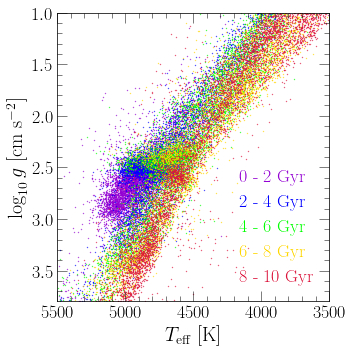

In [15]:
N_SAMPLE = 5000
random.seed(a = 1)

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$T_\text{eff}$ [K]")
ax.set_ylabel(r"$\log_{10} g$ [cm s$^{-2}$]")
ax.set_xlim([3500, 5500])
ax.set_ylim([1, 3.8])
ax.invert_xaxis()
ax.invert_yaxis()


age_bins = [0, 2, 4, 6, 8, 10]
colors = ["darkviolet", "blue", "lime", "gold", "crimson"]
for i in range(len(colors)):
    subsample = sample.filter(
        "ASTRONN_AGE", ">=", age_bins[i]).filter(
        "ASTRONN_AGE", "<=", age_bins[i + 1]).filter(
        "ABSZ", ">=", 0).filter(
        "ABSZ", "<=", 0.5)
    indices = random.sample(range(len(subsample["TEFF"])), N_SAMPLE)
    kwargs = {
        "c": named_colors()[colors[i]],
        "s": 0.1,
        "rasterized": True,
        "label": "%d - %d Gyr" % (age_bins[i], age_bins[i + 1])
    }
    teff = [subsample["TEFF"][idx] for idx in indices]
    logg = [subsample["LOGG"][idx] for idx in indices]
    ax.scatter(teff, logg, **kwargs)

# kwargs = {
#     "c": named_colors()["black"],
#     "linestyle": "--"
# }
# ax.plot([4250, ax.get_xlim()[0]], 2 * [2.5], **kwargs)
# ax.plot([4250, ax.get_xlim()[0]], 2 * [3.6], **kwargs)
    
kwargs = {
    "loc": mpl_loc("lower right"),
    "ncol": 1,
    "handlelength": 0
}
leg = ax.legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
plt.savefig("../paper/figures/kiel_diagram.pdf")
plt.show()

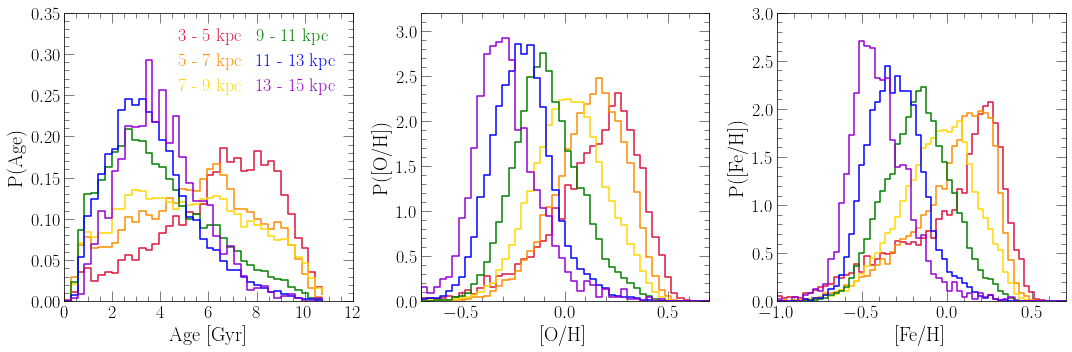

In [12]:
fig = plt.figure(figsize = (15, 5))
axes = []
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
axes[0].set_xlabel(r"Age [Gyr]")
axes[0].set_ylabel(r"P(Age)")
axes[0].set_xlim([0, 12])
axes[0].set_xticks([0, 2, 4, 6, 8, 10, 12])
axes[0].set_ylim([0, 0.35])
axes[1].set_xlabel(r"[O/H]")
axes[1].set_ylabel(r"P([O/H])")
axes[1].set_xlim([-0.7, 0.7])
axes[1].set_ylim([0, 3.2])
axes[2].set_xlabel(r"[Fe/H]")
axes[2].set_ylabel(r"P([Fe/H])")
axes[2].set_xlim([-1, 0.7])
axes[2].set_ylim([0, 3])

radial_bins = [3, 5, 7, 9, 11, 13, 15]
colors = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]

age_bins = np.linspace(0, 11, 40)
xh_bins = np.linspace(-2, 1, 100)

for i in range(len(radial_bins) - 1):
    subsample = sample.filter(
        "GALR", ">=", radial_bins[i]).filter(
        "GALR", "<=", radial_bins[i + 1]).filter(
        "ABSZ", ">=", 0).filter(
        "ABSZ", "<=", 0.5)
    
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": "%d - %d kpc" % (radial_bins[i], radial_bins[i + 1])
    }
    
    dist, _ = np.histogram(subsample["ASTRONN_AGE"], bins = age_bins, density = True)
    axes[0].step(age_bins[:-1], dist, where = "post", **kwargs)
    
    dist, _ = np.histogram(subsample["O_H"], bins = xh_bins, density = True)
    axes[1].step(xh_bins[:-1], dist, where = "post", **kwargs)
    
    dist, _ = np.histogram(subsample["FE_H"], bins = xh_bins, density = True)
    axes[2].step(xh_bins[:-1], dist, where = "post", **kwargs)
    
kwargs = {
    "loc": mpl_loc("upper right"),
    "ncol": 2,
    "handlelength": 0,
    "columnspacing": 0.5
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
plt.savefig("../paper/figures/age_xh_dists.pdf")
plt.show()

In [109]:
# def skewnormal(x, a, mean, std):
#     return 1 / std * skewnorm.pdf((x - mean) / std, a)

def skewnormal(x, a, mean, std):
    return skewnorm.pdf(x, a, mean, std)

# age_bins = list(range(11))
age_bins = list(range(0, 11, 2))
radial_bins = list(range(16))
with open("./paperfigures/age_gradoh_skewnormfits.out", "w") as f_oh:
    with open("./paperfigures/age_gradfeh_skewnormfits.out", "w") as f_fe:
        for f in [f_oh, f_fe]:
            f.write("# Columns:\n")
            f.write("# 0. age_min [Gyr]\n")
            f.write("# 1. age_max [Gyr]\n")
            f.write("# 2. r_min [kpc]\n")
            f.write("# 3. r_max [kpc]\n")
            f.write("# 4. a\n")
            f.write("# 5. err_a\n")
            f.write("# 6. mu\n")
            f.write("# 7. err_mu\n")
            f.write("# 8. std\n")
            f.write("# 9. err_std\n")
        for i in range(len(age_bins) - 1):
            subsample = sample.filter(
                "ASTRONN_AGE", ">=", age_bins[i]).filter(
                "ASTRONN_AGE", "<=", age_bins[i + 1]).filter(
                "GALZ", ">=", -0.5).filter(
                "GALZ", "<=", 0.5).filter(
                "O_H", ">=", -2).filter(
                "O_H", "<=", 2).filter(
                "FE_H", ">=", -2).filter(
                "FE_H", "<=", 2)
            for j in range(len(radial_bins) - 1):
                for f in [f_oh, f_fe]: f.write("%.3e\t%.3e\t" % (age_bins[i], age_bins[i + 1]))
                for f in [f_oh, f_fe]: f.write("%.3e\t%.3e\t" % (radial_bins[j], radial_bins[j + 1]))
                sys.stdout.write("\rage = %d - %d Gyr ; R = %d - %d kpc       " % (
                    age_bins[i], age_bins[i + 1], radial_bins[j], radial_bins[j + 1]))
                sys.stdout.flush()
                subsubsample = subsample.filter(
                    "GALR", ">=", radial_bins[j]).filter( 
                    "GALR", "<=", radial_bins[j + 1])
                if len(subsubsample["O_H"]) >= 500:
#                     bins = np.linspace(-2, 2, 101)
                    bounds = [[-1, -1, 0], [1, 1, 1]]
                    dist, bins = np.histogram(subsubsample["O_H"], bins = 50, density = True)
                    centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
                    opt, cov = curve_fit(skewnormal, centers, dist)
                    errs = np.sqrt(np.diag(cov))
                    for k in range(len(opt)):
                        if abs(errs[k]) > abs(opt[k]): errs[k] = abs(opt[k])
                        f_oh.write("%.3e\t%.3e\t" % (opt[k], errs[k]))
#                             print(abs(errs[k]), abs(opt[k]))
#                             print(max(subsubsample["O_H"]))
#                             if k == 0:
#                                 plt.plot(centers, dist)
#                                 plt.show()
                    f_oh.write("\n")
                else:
                    f_oh.write("nan\tnan\tnan\tnan\tnan\tnan\n")
                if len(subsubsample["FE_H"]) >= 500:
                    dist, bins = np.histogram(subsubsample["FE_H"], bins = 50, density = True)
                    centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
                    opt, cov = curve_fit(skewnormal, centers, dist)
                    errs = np.sqrt(np.diag(cov))
                    for k in range(3):
                        if abs(errs[k]) > abs(opt[k]): errs[k] = abs(opt[k])
                        f_fe.write("%.3e\t%.3e\t" % (opt[k], errs[k]))
                    f_fe.write("\n")
                else:
                    f_fe.write("nan\tnan\tnan\tnan\tnan\tnan\n")
        sys.stdout.write("\n")
        f.close()

age = 8 - 10 Gyr ; R = 14 - 15 kpc       


Age: 0 - 2 Gyr
Slope: -0.057 +/- 0.009
Intercept: 0.473 +/- 0.082
Age: 2 - 4 Gyr
Slope: -0.066 +/- 0.006
Intercept: 0.546 +/- 0.054
24.35 3.645 0.2281
Age: 4 - 6 Gyr
Slope: -0.084 +/- 0.005
Intercept: 0.710 +/- 0.047
Age: 6 - 8 Gyr
Slope: -0.054 +/- 0.006
Intercept: 0.522 +/- 0.048
6997.0 1272.0 6.507
Age: 8 - 10 Gyr
Slope: -0.046 +/- 0.013
Intercept: 0.403 +/- 0.078
Age: 0 - 2 Gyr
Slope: -0.075 +/- 0.008
Intercept: 0.637 +/- 0.076
Age: 2 - 4 Gyr
Slope: -0.086 +/- 0.006
Intercept: 0.666 +/- 0.052
0.9615 0.1493 0.06333
Age: 4 - 6 Gyr
Slope: -0.103 +/- 0.009
Intercept: 0.798 +/- 0.077
Age: 6 - 8 Gyr
Slope: -0.066 +/- 0.011
Intercept: 0.554 +/- 0.081
Age: 8 - 10 Gyr
Slope: -0.074 +/- 0.027
Intercept: 0.451 +/- 0.164


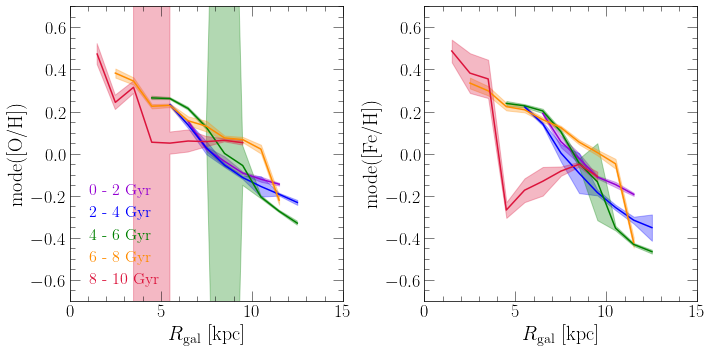

In [110]:
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for ax in [ax1, ax2]:
    ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
    ax.set_xlim([0, 15])
    ax.set_ylim([-0.7, 0.7])
ax1.set_ylabel(r"mode([O/H])")
ax2.set_ylabel(r"mode([Fe/H])")
axes = [ax1, ax2]
random.seed(a = 1)

def mode_of_skewnorm(a, mean, std):
    delta = a / np.sqrt(1 + a**2)
    term1 = (4 - np.pi) / 2 * delta**3 / (np.pi - 2 * delta**2)
    sgn = int(a > 0) - int(a < 0)
    factor = np.sqrt(2 / np.pi) * (delta - term1) - sgn / 2 * np.exp(-2 * np.pi / abs(a))
    return mean + std * factor

class line:
    
    def __init__(self, slope, intercept):
        self.slope = slope
        self.intercept = intercept
        
    def __call__(self, x):
        return self.slope * x + self.intercept

# age_bins = list(range(11))
age_bins = list(range(0, 11, 2))
radial_bins = list(range(16))
# colors = ["violet", "darkviolet", "navy", "blue", "green", "lime", "gold", "darkorange", "crimson", "firebrick"]
colors = ["darkviolet", "blue", "green", "darkorange", "crimson"]
# colors = ["purple", "blue", "lime", "crimson", "black"]

filenames = ["./paperfigures/age_gradoh_skewnormfits.out", "./paperfigures/age_gradfeh_skewnormfits.out"]
for k in range(len(filenames)):
    raw = np.genfromtxt(filenames[k])
    for i in range(len(age_bins) - 1):
#     for i in range(1):
        fits = raw[i * (len(radial_bins) - 1) : (i + 1) * (len(radial_bins) - 1)]
        radii = []
        xh = []
        err_a = []
        err_mu = []
        err_std = []
        err_mode = []
        for j in range(len(fits)):
            if not any([np.isnan(_) for _ in fits[j][4:]]):
                radii.append((fits[j][2] + fits[j][3]) / 2)
                xh.append(mode_of_skewnorm(fits[j][4], fits[j][6], fits[j][8]))
                err_a.append(fits[j][5])
                err_mu.append(fits[j][7])
                err_std.append(fits[j][9])
                modes = []
                for _ in range(1000):
                    a = np.random.normal(loc = fits[j][4], scale = fits[j][5])
                    mu = np.random.normal(loc = fits[j][6], scale = fits[j][7])
                    std = np.random.normal(loc = fits[j][8], scale = fits[j][9])
                    modes.append(mode_of_skewnorm(a, mu, std))
                err_mode.append(np.std(modes))
                if err_mode[-1] > 0.1:
                    print(fits[j][5], fits[j][7], fits[j][9])
                else: pass
            else: pass
        kwargs = {
            "c": named_colors()[colors[i]],
#             "marker": markers()['plus'],
            "zorder": 100,
            "label": r"%d - %d Gyr" % (age_bins[i], age_bins[i + 1])
        }
        axes[k].plot(radii, xh, **kwargs)
        axes[k].fill_between(radii, [a - b for a, b in zip(xh, err_mode)], [a + b for a, b in zip(xh, err_mode)],
            alpha = 0.3, color = kwargs["c"])
        regression = linregress(radii, xh)
        print("Age: %d - %d Gyr" % (age_bins[i], age_bins[i + 1]))
        print("Slope: %.3f +/- %.3f" % (regression.slope, regression.stderr))
        print("Intercept: %.3f +/- %.3f" % (regression.intercept, regression.intercept_stderr))
        print("==================================")
#         bestfit = line(regression.slope, regression.intercept)
#         elem = ["O", "Fe"][k]
#         kwargs["label"] = r"$\tau = %d - %d$ Gyr" "\n" r"$\nabla$[%s/H] = $%.3f \pm %.3f$ kpc$^{-1}$" % (
#             age_bins[i], age_bins[i + 1], elem, regression.slope, regression.stderr)
#         kwargs["zorder"] = 0
#         axes[k].plot(axes[k].get_xlim(), [bestfit(_) for _ in axes[k].get_xlim()], **kwargs)

kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0,
#     "columnspacing": 0.5,
#     "ncol": 2,
    "fontsize": 16
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
plt.show()

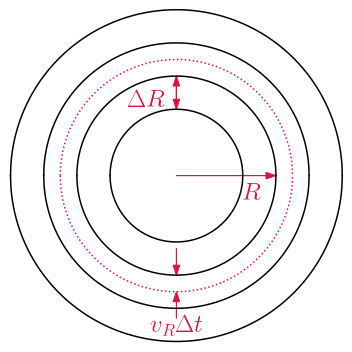

In [2]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlim([-5.1, 5.1])
ax.set_ylim([-5.1, 5.1])
ax.axis("off")

def plot_circle(radius, **kwargs):
    xvals = np.linspace(-radius, radius, 1000)
    yvals = [np.sqrt(radius**2 - x**2) for x in xvals]
    ax.plot(xvals, yvals, **kwargs)
    yvals = [-np.sqrt(radius**2 - x**2) for x in xvals]
    ax.plot(xvals, yvals, **kwargs)

kwargs = {"c": named_colors()["black"]}
for _ in [2, 3, 4, 5]: plot_circle(_, **kwargs)
plot_circle(3.5, c = named_colors()["crimson"], linestyle = ':')
kwargs = {
    "color": named_colors()["crimson"],
    "length_includes_head": True,
    "head_width": 0.2
}
ax.arrow(0, 0, 3, 0, **kwargs)
ax.arrow(0, 2, 0, 1, **kwargs)
ax.arrow(0, 3, 0, -1, **kwargs)
ax.arrow(0, -4.3, 0, 0.8, **kwargs)
ax.arrow(0, -2.2, 0, -0.8, **kwargs)
ax.text(-1.5, 2.1, r"$\Delta R$", color = kwargs["color"], fontsize = 25)
ax.text(2, -0.7, r"$R$", color = kwargs["color"], fontsize = 25)
ax.text(-0.8, -4.7, r"$v_R \Delta t$", color = kwargs["color"], fontsize = 25)

plt.tight_layout()
plt.savefig("../paper/figures/radialflows_schematic.pdf")
plt.show()

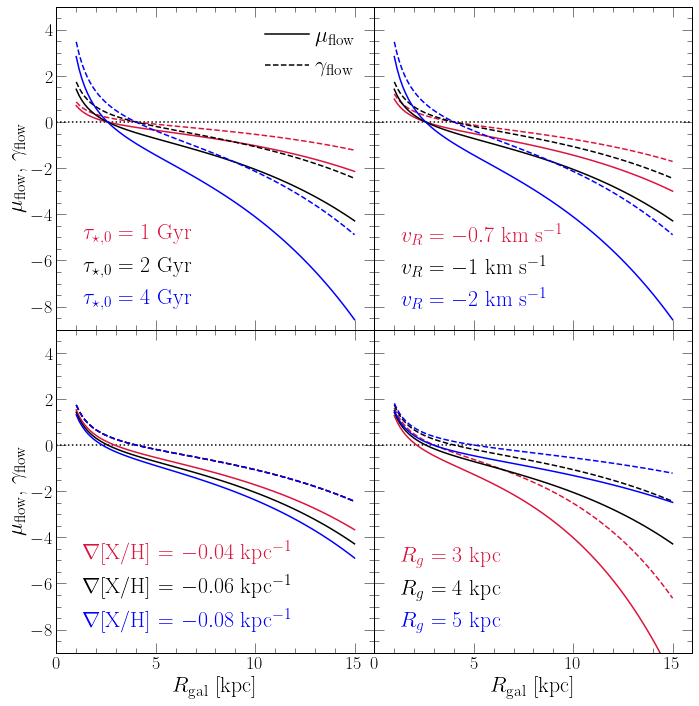

In [6]:
_SECONDS_PER_GYR_ = 3.1536e16
_KM_PER_KPC_ = 3.24e-17

def ralpha(A):
    r"""
    The e-folding scale radius of the metallicity gradient by mass.
    
    See :math:`R_\alpha` in notes above.
    """
    return -1 / (A * np.log(10))

def mu_flow(taustar, vr, A, rg, R):
    vr *= _SECONDS_PER_GYR_
    vr *= _KM_PER_KPC_ # vr now in kpc / Gyr
    return -taustar * vr * (1 / R - 1 / rg - 1 / ralpha(A))

def gamma_flow(taustar, vr, rg, R):
    vr *= _SECONDS_PER_GYR_
    vr *= _KM_PER_KPC_
    return -taustar * vr * (1 / R - 1 / rg)

def tau_star(radius, taustar0 = 2, Rg = 4, N = 1.5):
    return taustar0 * np.exp((N - 1) * radius / Rg)

fig = plt.figure(figsize = (10, 10))
axes = []
for i in range(4):
    kwargs = {}
    if i: kwargs["sharey"] = axes[0]
    axes.append(fig.add_subplot(221 + i, **kwargs))
    if i == 0 or i == 2:
#         axes[i].set_ylabel(r"$\mu_\text{flow} \equiv \dot{M}_{\alpha,\text{flow}} / \dot{M}_\star$",
#             fontsize = 22)
        axes[i].set_ylabel(r"$\mu_\text{flow}$, $\gamma_\text{flow}$", fontsize = 22)
    else:
        plt.setp(axes[i].get_yticklabels(), visible = False)
    if i >= 2:
        axes[i].set_xlabel(r"$R_\text{gal}$ [kpc]", fontsize = 22)
    else:
        plt.setp(axes[i].get_xticklabels(), visible = False)
    axes[i].set_xlim([0, 16])
    axes[i].set_ylim([-9, 5])
    axes[i].axhline(0, c = named_colors()["black"], linestyle = ':')
    
kwargs = {
    "c": named_colors()["black"],
    "label": r"$\mu_\text{flow}$"
}
line1 = axes[0].plot([-10, -20], [-10, -20], **kwargs)[0]
kwargs["linestyle"] = "--"
kwargs["label"] = r"$\gamma_\text{flow}$"
line2 = axes[0].plot([-10, -20], [-10, -20], **kwargs)[0]
kwargs = {
    "loc": mpl_loc("upper right"),
    "fontsize": 22
}
leg = axes[0].legend(**kwargs)
axes[0].add_artist(leg)
line1.remove()
line2.remove()

colors = ["crimson", "black", "blue"]
taustar0 = [1, 2, 4]
vr = [-0.7, -1, -2]
A = [-0.04, -0.06, -0.08]
rg = [3, 4, 5]

xvals = np.linspace(1, 15, 100)

for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$\tau_{\star,0} = %g$ Gyr" % (taustar0[i])
    }
#     yvals = [mu_flow(taustar[i], vr[1], A[1], rg[1], x) for x in xvals]
    yvals = [mu_flow(tau_star(x, taustar0 = taustar0[i]), vr[1], A[1], rg[1], x) for x in xvals]
    axes[0].plot(xvals, yvals, **kwargs)
    kwargs["linestyle"] = "--"
    kwargs["label"] = None
    yvals = [gamma_flow(tau_star(x, taustar0 = taustar0[i]), vr[1], rg[1], x) for x in xvals]
    axes[0].plot(xvals, yvals, **kwargs)
    
for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$v_R = %g$ km s$^{-1}$" % (vr[i])
    }
#     yvals = [mu_flow(taustar[1], vr[i], A[1], rg[1], x) for x in xvals]
    yvals = [mu_flow(tau_star(x, taustar0 = taustar0[1]), vr[i], A[1], rg[1], x) for x in xvals]
    axes[1].plot(xvals, yvals, **kwargs)
    kwargs["linestyle"] = "--"
    kwargs["label"] = None
    yvals = [gamma_flow(tau_star(x, taustar0 = taustar0[1]), vr[i], rg[1], x) for x in xvals]
    axes[1].plot(xvals, yvals, **kwargs)
    
for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$\nabla$[X/H] = $%g$ kpc$^{-1}$" % (A[i])
    }
#     yvals = [mu_flow(taustar[1], vr[1], A[i], rg[1], x) for x in xvals]
    yvals = [mu_flow(tau_star(x, taustar0 = taustar0[1]), vr[1], A[i], rg[1], x) for x in xvals]
    axes[2].plot(xvals, yvals, **kwargs)
    kwargs["linestyle"] = "--"
    kwargs["label"] = None
    yvals = [gamma_flow(tau_star(x, taustar0 = taustar0[1]), vr[1], rg[1], x) for x in xvals]
    axes[2].plot(xvals, yvals, **kwargs)

for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$R_g = %g$ kpc" % (rg[i])
    }
#     yvals = [mu_flow(taustar[1], vr[1], A[1], rg[i], x) for x in xvals]
    yvals = [mu_flow(tau_star(x, taustar0 = taustar0[1], Rg = rg[i]), vr[1], A[1], rg[i], x) for x in xvals]
    axes[3].plot(xvals, yvals, **kwargs)
    kwargs["linestyle"] = "--"
    kwargs["label"] = None
    yvals = [gamma_flow(tau_star(x, taustar0 = taustar0[1], Rg = rg[i]), vr[1], rg[i], x) for x in xvals]
    axes[3].plot(xvals, yvals, **kwargs)

for i in range(4):
    kwargs = {
        "loc": mpl_loc("lower left"),
        "handlelength": 0,
        "fontsize": 22
    }
    leg = axes[i].legend(**kwargs)
    fancy_legend(leg, colors)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
plt.savefig("../paper/figures/muflow_gammaflow_vs_radius.pdf")
plt.show()